# HW 2: Deep Bag-of-Words

![words.jpeg](https://cdn-images-1.medium.com/max/1600/0*JpqZhCNsQ_OGaRkB.jpg)

<br>

In this homework, you will be implementing a deep averaging network, detailed in [Deep Unordered Composition  Rivals Syntactic Methods for Text Classification by Iyyer et al. (2015)](https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf) and training it to do sentiment analysis on the Stanford Sentiment Treebank.

<br>

**Please use all of the starter code that is provided, do not make any changes to the data processing, evaluation, and training functions. Only add code were you're asked to.**

<br>

# Part 0: Read Paper!

Read [Deep Unordered Composition  Rivals Syntactic Methods for Text Classification by Iyyer et al. (2015)](https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf).

## Data Processing

Make sure you've downloaded the Stanford Sentiment Treebank that was used in lab. You can find it [here](http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip).

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import re
import random

from IPython.core.debugger import set_trace

random.seed(1)
sst_home = '../data/trees'

# Let's do 2-way positive/negative classification instead of 5-way
easy_label_map = {0:0, 1:0, 2:None, 3:1, 4:1}
    # so labels of 0 and 1 in te 5-wayclassificaiton are 0 in the 2-way. 3 and 4 are 1, and 2 is none
    # because we don't have a neautral class. 

PADDING = "<PAD>"
UNKNOWN = "<UNK>"
max_seq_length = 20

def load_sst_data(path):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)

    random.seed(1)
    random.shuffle(data)
    return data
     
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

<br>

Next, we'll extract the vocabulary from the data, index each token, and finally convert the sentences into lists of indexed tokens. We are also padding and truncating all sentences to be of length=20. (Why? Think about how to handle batching. This is certainly not the only way! This is just simple.)

In [13]:
import collections
import numpy as np

def tokenize(string):
    return string.split()

def build_dictionary(training_datasets):
    """
    Extract vocabulary and build dictionary.
    """  
    word_counter = collections.Counter()
    for i, dataset in enumerate(training_datasets):
        for example in dataset:
            word_counter.update(tokenize(example['text']))
        
    vocabulary = set([word for word in word_counter])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))

    return word_indices, len(vocabulary)

def sentences_to_padded_index_sequences(word_indices, datasets):
    """
    Annotate datasets with feature vectors. Adding right-sided padding. 
    """
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['text_index_sequence'] = torch.zeros(max_seq_length)

            token_sequence = tokenize(example['text'])
            padding = max_seq_length - len(token_sequence)

            for i in range(max_seq_length):
                if i >= len(token_sequence):
                    index = word_indices[PADDING]
                    pass
                else:
                    if token_sequence[i] in word_indices:
                        index = word_indices[token_sequence[i]]
                    else:
                        index = word_indices[UNKNOWN]
                example['text_index_sequence'][i] = index

            example['text_index_sequence'] = example['text_index_sequence'].long().view(1,-1)
            example['label'] = torch.LongTensor([example['label']])


word_to_ix, vocab_size = build_dictionary([training_set])
sentences_to_padded_index_sequences(word_to_ix, [training_set, dev_set, test_set])

In [14]:
print("Size of training dataset:", len(training_set))
print("\nFirst padded and indexified example in training data:\n", training_set[0])

Size of training dataset: 6920

First padded and indexified example in training data:
 {'label': tensor([0]), 'text': 'Yet another entry in the sentimental oh-those-wacky-Brits genre that was ushered in by The Full Monty and is still straining to produce another smash hit .', 'text_index_sequence': tensor([[ 6630, 14958,  5529, 11731, 10404,  6018,  5996,  3578,  1604, 15477,
         15994, 11731,  2252, 14478, 14779, 15470, 13751,  2930,  9065,  3418]])}


### Batichify data
We're going to be doign mini-batch training. The following code makes data iterators and a batchifying function.

In [15]:
# This is the iterator we'll use during training. 
# It's a generator that gives you one batch at a time.
def data_iter(source, batch_size):
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while True:
        start += batch_size
        if start > dataset_size - batch_size:
            # Start another epoch.
            start = 0
            random.shuffle(order)   
        batch_indices = order[start:start + batch_size]
        batch = [source[index] for index in batch_indices]
        yield [source[index] for index in batch_indices]

# This is the iterator we use when we're evaluating our model. 
# It gives a list of batches that you can then iterate through.
def eval_iter(source, batch_size):
    batches = []
    dataset_size = len(source)
    start = -1 * batch_size
    order = list(range(dataset_size))
    random.shuffle(order)

    while start < dataset_size - batch_size:
        start += batch_size
        batch_indices = order[start:start + batch_size]
        batch = [source[index] for index in batch_indices]
        if len(batch) == batch_size:
            batches.append(batch)
        else:
            continue
        
    return batches

# The following function gives batches of vectors and labels, 
# these are the inputs to your model and loss function
def get_batch(batch):
    vectors = []
    labels = []
    for dict in batch:
        vectors.append(dict["text_index_sequence"])
        labels.append(dict["label"])
    return vectors, labels


## Evaluation

We'll be looking at accuracy as our evaluation metric.

In [16]:
# This function outputs the accuracy on the dataset, we will use it during training.
def evaluate(model, data_iter):
    model.eval()
    correct = 0
    total = 0
    for i in range(len(data_iter)):
        vectors, labels = get_batch(data_iter[i])
        vectors = torch.stack(vectors).squeeze()
        labels = torch.stack(labels).squeeze()

        output = model(vectors)
        
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      
    return correct / float(total)

<br>

## Training Loop

The following function trains the model and reports model accuracy on the train and dev set every 5 epochs.

In [17]:
def training_loop(batch_size, num_epochs, model, loss_, optim, training_iter, dev_iter,
                  train_eval_iter, verbose=True):
    step = 0
    epoch = 0
    total_batches = int(len(training_set) / batch_size)
    accuracies = []
    while epoch <= num_epochs:
        model.train()
        vectors, labels = get_batch(next(training_iter)) 
        vectors = torch.stack(vectors).squeeze() # batch_size, seq_len
        labels = torch.stack(labels).squeeze()
        
    
        model.zero_grad()
        
        output = model(vectors)

        lossy = loss_(output, labels)
        lossy.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optim.step()
        

        if step % total_batches == 0:
            model.eval()
            if epoch % 5 == 0:
                
                train_acc = evaluate(model, train_eval_iter)
                eval_acc = evaluate(model, dev_iter)
                accuracies.append(eval_acc)
                if verbose:
                    print("Epoch %i; Step %i; Loss %f; Train acc: %f; Dev acc %f" 
                          %(epoch, step, lossy.item(),\
                            train_acc, eval_acc))
            epoch += 1
        step += 1
    
    best_dev = max(accuracies)
    print("Best dev accuracy is {}".format(best_dev))
    return best_dev

<br>

# Part 1: Implement DAN (40 points)

Following the [paper](https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf), implement the Deep Averaging Network (DAN).

Implementation details,
- Instead of using \code{tanh} activations however, use \code{ReLU}. 
- Make the number of layers a variable, not a fixed value.
- Make sure to implement word-dropout.

In [18]:
class DAN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, 
                 batch_size, n_layers, drop_rate):
        super(DAN, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding_size = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.drop_rate = drop_rate
        
        """
        YOUR CODE GOES HERE
        """
        
        self.layer_0 = nn.Linear(embedding_dim, hidden_size)
        
        for i in range(1, self.n_layers):
            setattr(self, 'l{}'.format(i), nn.Linear(hidden_size, hidden_size))
        
        self.decoder = nn.Linear(hidden_size, output_size)
        """
        """

        self.init_weights()
    
    def forward(self, input):
        """
        YOUR CODE GOES HERE
        """
        x_emb = self.embed(input)   # Get embedding of each word

        if self.training:           # Dropout words in training step
            av = []
            for sent in x_emb:
                new_sent = []
                mask = np.random.rand(len(sent)) > drop_rate
                
                for index, keep in enumerate(mask):
                    if keep:
                        new_sent.append(sent[index])
                
                # Each sentence should at least have one word
                if not new_sent:
                    
                    for j in range(len(sent)):
                        new_sent.append(sent[j])
                    set_trace()

                new_sent = torch.stack(new_sent, 0)
                av.append(torch.mean(new_sent, 0))    # append the average embedding to av
                
            av = torch.stack(av, 0)
        
        else:
            av = torch.mean(x_emb, 1)
        
        h = self.layer_0(av)
        lin_layers = []
        for i in range(1, self.n_layers):
            lin_layers.append(getattr(self, 'l{}'.format(i)))
        
        for layer in lin_layers:
            h = layer(h)
        
        output = torch.softmax(self.decoder(h),1)
        """
        """        
        return output

    def init_hidden(self):
        h0 = torch.zeros(self.batch_size, self.hidden_size)
        return h0
    
    def init_weights(self):
        initrange = 0.1
        lin_layers = [self.layer_0, self.decoder]
        for i in range(1, self.n_layers):
            lin_layers.append(getattr(self, 'l{}'.format(i)))
        em_layer =  [self.embed]
     
        for layer in lin_layers+em_layer:
            layer.weight.data.uniform_(-initrange, initrange)
            if layer in lin_layers:
                layer.bias.data.fill_(0)

### Train the model!

** Please use the hyperparameters and optimizer provided below. Do not make changes here. **

In [27]:
# Hyperparameters 
input_size = vocab_size
num_labels = 2
hidden_dim = 24
embedding_dim = 8
batch_size = 256
num_layers = 2
learning_rate = 0.001
drop_rate = 0.4
num_epochs = 30


# Build and initialize the model
dan = DAN(vocab_size, embedding_dim, hidden_dim, num_labels, batch_size, num_layers, drop_rate)
dan.init_weights()

# Define loss function and optimizer
loss = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(dan.parameters(), lr=learning_rate)

# Build data iterators
training_iter = data_iter(training_set, batch_size)
train_eval_iter = eval_iter(training_set[0:500], batch_size)
dev_iter = eval_iter(dev_set[:500], batch_size)

# Train the model
training_loop(batch_size, num_epochs, dan, loss, optimizer, training_iter, dev_iter, train_eval_iter)

Epoch 0; Step 0; Loss 0.693148; Train acc: 0.460938; Dev acc 0.468750
Epoch 5; Step 135; Loss 0.619379; Train acc: 0.742188; Dev acc 0.695312
Epoch 10; Step 270; Loss 0.417765; Train acc: 0.910156; Dev acc 0.796875
Epoch 15; Step 405; Loss 0.414722; Train acc: 0.949219; Dev acc 0.789062
Epoch 20; Step 540; Loss 0.385289; Train acc: 0.964844; Dev acc 0.812500
Epoch 25; Step 675; Loss 0.372346; Train acc: 0.980469; Dev acc 0.828125
Epoch 30; Step 810; Loss 0.361986; Train acc: 0.988281; Dev acc 0.820312
Best dev accuracy is 0.828125


0.828125

<br>

# Part 2: Hyperparameter tuning (40 points)

Tune the DAN for learning rate, number of layers, and drop-out rate. Select a range for each parameter and then do a random search over these hyperparameters, trying a minimum 5 permutations of hyperparameters. Report results and the best hyperparameters you found. Do you see any patterns in your results?

### Step 1. Select a range for each hyperparameter

In [28]:
import numpy as np
import matplotlib.pyplot as plt

input_size = vocab_size
num_labels = 2
hidden_dim = 24
embedding_dim = 8
batch_size = 256
num_layers = 2
learning_rate = 0.001
drop_rate = 0.4
max_seq_length = 20
num_epochs = 30

param_dic = {"learning_rate" : [0.0008, 0.0009, 0.001, 0.0011, 0.0012, 0.002, 0.003], 
             "num_layers" : [1, 2, 3, 4, 5, 6], 
             "drop_rate" : [0, 0.2, 0.3, 0.4, 0.45]}

#### 1-1. learning_rate

In [38]:
num_layers = 2
learning_rate = 0.001
drop_rate = 0.4

learning_rate_acc = []
# Search learning_rate
for i in range(len(param_dic["learning_rate"])):
    print("(Search %d) learning_rate = %s" % (i+1, str(param_dic["learning_rate"][i])))
    learning_rate = param_dic["learning_rate"][i]

    # Build and initialize the model
    dan = DAN(vocab_size, embedding_dim, hidden_dim, num_labels, batch_size, num_layers, drop_rate)
    dan.init_weights()

    # Define loss function and optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(dan.parameters(), lr=learning_rate)

    # Build data iterators
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[:500], batch_size)

    # Train the model
    acc = training_loop(batch_size, num_epochs, dan, loss, optimizer, training_iter, dev_iter, train_eval_iter)
    learning_rate_acc.append(acc)
    print()

(Search 1) learning_rate = 0.0008
Epoch 0; Step 0; Loss 0.693139; Train acc: 0.507812; Dev acc 0.535156
Epoch 5; Step 135; Loss 0.658259; Train acc: 0.656250; Dev acc 0.621094
Epoch 10; Step 270; Loss 0.466037; Train acc: 0.851562; Dev acc 0.765625
Epoch 15; Step 405; Loss 0.440024; Train acc: 0.949219; Dev acc 0.792969
Epoch 20; Step 540; Loss 0.397193; Train acc: 0.968750; Dev acc 0.785156
Epoch 25; Step 675; Loss 0.396816; Train acc: 0.984375; Dev acc 0.789062
Epoch 30; Step 810; Loss 0.377116; Train acc: 0.984375; Dev acc 0.789062
Best dev accuracy is 0.79296875

(Search 2) learning_rate = 0.0009
Epoch 0; Step 0; Loss 0.693152; Train acc: 0.484375; Dev acc 0.500000
Epoch 5; Step 135; Loss 0.631062; Train acc: 0.746094; Dev acc 0.644531
Epoch 10; Step 270; Loss 0.465599; Train acc: 0.914062; Dev acc 0.761719
Epoch 15; Step 405; Loss 0.422594; Train acc: 0.968750; Dev acc 0.800781
Epoch 20; Step 540; Loss 0.396941; Train acc: 0.976562; Dev acc 0.835938
Epoch 25; Step 675; Loss 0.3668

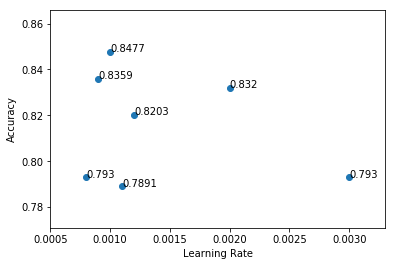

In [39]:
plt.scatter(param_dic["learning_rate"], learning_rate_acc)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xlim(param_dic["learning_rate"][0] - 0.0003, param_dic["learning_rate"][-1] + 0.0003)
for x, y in zip(param_dic["learning_rate"], learning_rate_acc):
    plt.text(x, y, str(round(y, 4)))
plt.show()

__Pattern:__ The accuracy seems to be at high values(over 0.83) around learning rate [0.0008, 0.0012]. I will check this range in random search. The accuracy drops dramatically for learning rate higher than 0.002.

#### 1-2. num_layers

In [36]:
num_layers = 2
learning_rate = 0.001
drop_rate = 0.4

num_layers_acc = []
# Search num_layers
for i in range(len(param_dic["num_layers"])):
    print("(Search %d) num_layers = %s" % (i+1, str(param_dic["num_layers"][i])))
    num_layers = param_dic["num_layers"][i]

    # Build and initialize the model
    dan = DAN(vocab_size, embedding_dim, hidden_dim, num_labels, batch_size, num_layers, drop_rate)
    dan.init_weights()

    # Define loss function and optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(dan.parameters(), lr=learning_rate)

    # Build data iterators
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[:500], batch_size)

    # Train the model
    acc = training_loop(batch_size, num_epochs, dan, loss, optimizer, training_iter, dev_iter, train_eval_iter)
    num_layers_acc.append(acc)
    print()

(Search 1) num_layers = 1
Epoch 0; Step 0; Loss 0.693091; Train acc: 0.527344; Dev acc 0.464844
Epoch 5; Step 135; Loss 0.648788; Train acc: 0.675781; Dev acc 0.593750
Epoch 10; Step 270; Loss 0.523492; Train acc: 0.878906; Dev acc 0.765625
Epoch 15; Step 405; Loss 0.445006; Train acc: 0.937500; Dev acc 0.785156
Epoch 20; Step 540; Loss 0.428633; Train acc: 0.964844; Dev acc 0.789062
Epoch 25; Step 675; Loss 0.392082; Train acc: 0.984375; Dev acc 0.789062
Epoch 30; Step 810; Loss 0.394962; Train acc: 0.984375; Dev acc 0.789062
Best dev accuracy is 0.7890625

(Search 2) num_layers = 2
Epoch 0; Step 0; Loss 0.693154; Train acc: 0.527344; Dev acc 0.542969
Epoch 5; Step 135; Loss 0.600979; Train acc: 0.789062; Dev acc 0.777344
Epoch 10; Step 270; Loss 0.441554; Train acc: 0.902344; Dev acc 0.820312
Epoch 15; Step 405; Loss 0.406136; Train acc: 0.941406; Dev acc 0.816406
Epoch 20; Step 540; Loss 0.397388; Train acc: 0.964844; Dev acc 0.777344
Epoch 25; Step 675; Loss 0.385184; Train acc: 0.

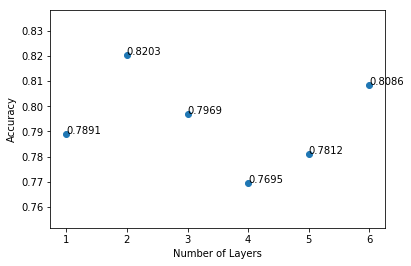

In [37]:
plt.scatter(param_dic["num_layers"], num_layers_acc)
plt.xlabel('Number of Layers')
plt.ylabel('Accuracy')
for x, y in zip(param_dic["num_layers"], num_layers_acc):
    plt.text(x, y, str(round(y, 4)))
plt.show()

__Pattern:__ The accuracy suddenly drops when the number of layers becomes 4 and more. This graph has a similar pattern with DAN paper's Figure 4, where the accuray increases until layer three and drops after 4. [1, 4] seems to be a good range to consider for random search.

#### 1-3. drop_rate

In [33]:
num_layers = 2
learning_rate = 0.001
drop_rate = 0.4

drop_rate_acc = []
# Search drop_rate
for i in range(len(param_dic["drop_rate"])):
    print("(Search %d) drop_rate = %s" % (i+1, str(param_dic["drop_rate"][i])))
    drop_rate = param_dic["drop_rate"][i]

    # Build and initialize the model
    dan = DAN(vocab_size, embedding_dim, hidden_dim, num_labels, batch_size, num_layers, drop_rate)
    dan.init_weights()

    # Define loss function and optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(dan.parameters(), lr=learning_rate)

    # Build data iterators
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[:500], batch_size)

    # Train the model
    acc = training_loop(batch_size, num_epochs, dan, loss, optimizer, training_iter, dev_iter, train_eval_iter)
    drop_rate_acc.append(acc)
    print()

(Search 1) drop_rate = 0
Epoch 0; Step 0; Loss 0.693165; Train acc: 0.500000; Dev acc 0.519531
Epoch 5; Step 135; Loss 0.557901; Train acc: 0.839844; Dev acc 0.777344
Epoch 10; Step 270; Loss 0.364223; Train acc: 0.976562; Dev acc 0.789062
Epoch 15; Step 405; Loss 0.338267; Train acc: 0.992188; Dev acc 0.773438
Epoch 20; Step 540; Loss 0.323144; Train acc: 0.996094; Dev acc 0.769531
Epoch 25; Step 675; Loss 0.321985; Train acc: 0.996094; Dev acc 0.757812
Epoch 30; Step 810; Loss 0.314224; Train acc: 0.996094; Dev acc 0.765625
Best dev accuracy is 0.7890625

(Search 2) drop_rate = 0.2
Epoch 0; Step 0; Loss 0.693140; Train acc: 0.535156; Dev acc 0.550781
Epoch 5; Step 135; Loss 0.565616; Train acc: 0.738281; Dev acc 0.710938
Epoch 10; Step 270; Loss 0.408517; Train acc: 0.949219; Dev acc 0.792969
Epoch 15; Step 405; Loss 0.349191; Train acc: 0.968750; Dev acc 0.796875
Epoch 20; Step 540; Loss 0.338436; Train acc: 0.972656; Dev acc 0.804688
Epoch 25; Step 675; Loss 0.331599; Train acc: 0.

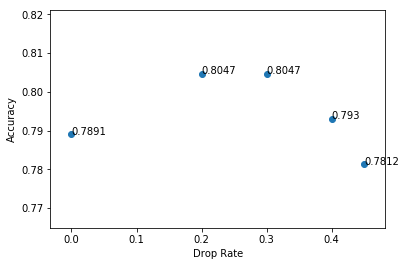

In [34]:
plt.scatter(param_dic["drop_rate"], drop_rate_acc)
plt.xlabel('Drop Rate')
plt.ylabel('Accuracy')
for x, y in zip(param_dic["drop_rate"], drop_rate_acc):
    plt.text(x, y, str(round(y, 4)))
plt.show()

__Pattern:__ The accuracy falls at drop rate 0.4. The original paper for DAN shows a similar result on Figure 2 and mentions that drop rate of 0.3 was optimal for one of its tasks. I will look into the range [0.2, 0.4) for random search.

### Step 2. Random Search

In [19]:
# Hypermeters that are same for all tests
input_size = vocab_size
num_labels = 2
hidden_dim = 24
embedding_dim = 8
batch_size = 256
max_seq_length = 20
num_epochs = 30

# Try 60 combinations
results = []
for i in range(60):
    print("(Search %d)" % (i))
    
    learning_rate = random.choice([0.0008, 0.0009, 0.001, 0.0011, 0.0012])
    num_layers = random.choice([1, 2, 3, 4])
    drop_rate = random.choice([0.2, 0.25, 0.3, 0.35])
    
    print("    learning_rate: %.4f" % learning_rate)
    print("    num_layers: %d" % num_layers)
    print("    drop_rate: %.2f" % drop_rate)

    # Build and initialize the model
    dan = DAN(vocab_size, embedding_dim, hidden_dim, num_labels, batch_size, num_layers, drop_rate)
    dan.init_weights()

    # Define loss function and optimizer
    loss = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(dan.parameters(), lr=learning_rate)

    # Build data iterators
    training_iter = data_iter(training_set, batch_size)
    train_eval_iter = eval_iter(training_set[0:500], batch_size)
    dev_iter = eval_iter(dev_set[:500], batch_size)

    # Train the model
    acc = training_loop(batch_size, num_epochs, dan, loss, optimizer, training_iter, dev_iter, train_eval_iter)
    results.append([acc, i])
    print()

(Search 0)
    learning_rate: 0.0012
    num_layers: 4
    drop_rate: 0.25
Epoch 0; Step 0; Loss 0.693148; Train acc: 0.539062; Dev acc 0.539062
Epoch 5; Step 135; Loss 0.492182; Train acc: 0.839844; Dev acc 0.746094
Epoch 10; Step 270; Loss 0.398030; Train acc: 0.945312; Dev acc 0.820312
Epoch 15; Step 405; Loss 0.362300; Train acc: 0.972656; Dev acc 0.792969
Epoch 20; Step 540; Loss 0.356329; Train acc: 0.976562; Dev acc 0.796875
Epoch 25; Step 675; Loss 0.362534; Train acc: 0.988281; Dev acc 0.800781
Epoch 30; Step 810; Loss 0.341245; Train acc: 0.996094; Dev acc 0.792969
Best dev accuracy is 0.8203125

(Search 1)
    learning_rate: 0.0010
    num_layers: 1
    drop_rate: 0.20
Epoch 0; Step 0; Loss 0.693100; Train acc: 0.476562; Dev acc 0.468750
Epoch 5; Step 135; Loss 0.646240; Train acc: 0.746094; Dev acc 0.726562
Epoch 10; Step 270; Loss 0.463922; Train acc: 0.882812; Dev acc 0.808594
Epoch 15; Step 405; Loss 0.404402; Train acc: 0.957031; Dev acc 0.820312
Epoch 20; Step 540; Los

Epoch 10; Step 270; Loss 0.369361; Train acc: 0.949219; Dev acc 0.792969
Epoch 15; Step 405; Loss 0.350226; Train acc: 0.964844; Dev acc 0.781250
Epoch 20; Step 540; Loss 0.356623; Train acc: 0.972656; Dev acc 0.800781
Epoch 25; Step 675; Loss 0.333981; Train acc: 0.980469; Dev acc 0.789062
Epoch 30; Step 810; Loss 0.331113; Train acc: 0.980469; Dev acc 0.804688
Best dev accuracy is 0.8046875

(Search 14)
    learning_rate: 0.0009
    num_layers: 4
    drop_rate: 0.20
Epoch 0; Step 0; Loss 0.693146; Train acc: 0.503906; Dev acc 0.519531
Epoch 5; Step 135; Loss 0.543360; Train acc: 0.785156; Dev acc 0.738281
Epoch 10; Step 270; Loss 0.385168; Train acc: 0.957031; Dev acc 0.789062
Epoch 15; Step 405; Loss 0.381304; Train acc: 0.976562; Dev acc 0.781250
Epoch 20; Step 540; Loss 0.365933; Train acc: 0.976562; Dev acc 0.773438
Epoch 25; Step 675; Loss 0.356542; Train acc: 0.980469; Dev acc 0.769531
Epoch 30; Step 810; Loss 0.343049; Train acc: 0.980469; Dev acc 0.765625
Best dev accuracy is

Epoch 25; Step 675; Loss 0.372909; Train acc: 0.980469; Dev acc 0.753906
Epoch 30; Step 810; Loss 0.359211; Train acc: 0.984375; Dev acc 0.773438
Best dev accuracy is 0.78515625

(Search 27)
    learning_rate: 0.0009
    num_layers: 1
    drop_rate: 0.20
Epoch 0; Step 0; Loss 0.693102; Train acc: 0.527344; Dev acc 0.562500
Epoch 5; Step 135; Loss 0.657282; Train acc: 0.656250; Dev acc 0.617188
Epoch 10; Step 270; Loss 0.486302; Train acc: 0.875000; Dev acc 0.769531
Epoch 15; Step 405; Loss 0.445535; Train acc: 0.937500; Dev acc 0.781250
Epoch 20; Step 540; Loss 0.407196; Train acc: 0.972656; Dev acc 0.777344
Epoch 25; Step 675; Loss 0.369116; Train acc: 0.984375; Dev acc 0.781250
Epoch 30; Step 810; Loss 0.364356; Train acc: 0.988281; Dev acc 0.777344
Best dev accuracy is 0.78125

(Search 28)
    learning_rate: 0.0011
    num_layers: 1
    drop_rate: 0.20
Epoch 0; Step 0; Loss 0.693136; Train acc: 0.523438; Dev acc 0.531250
Epoch 5; Step 135; Loss 0.631185; Train acc: 0.800781; Dev acc

Epoch 5; Step 135; Loss 0.589260; Train acc: 0.742188; Dev acc 0.691406
Epoch 10; Step 270; Loss 0.384187; Train acc: 0.957031; Dev acc 0.792969
Epoch 15; Step 405; Loss 0.371384; Train acc: 0.972656; Dev acc 0.785156
Epoch 20; Step 540; Loss 0.365870; Train acc: 0.980469; Dev acc 0.789062
Epoch 25; Step 675; Loss 0.362673; Train acc: 0.992188; Dev acc 0.781250
Epoch 30; Step 810; Loss 0.342476; Train acc: 0.992188; Dev acc 0.785156
Best dev accuracy is 0.79296875

(Search 41)
    learning_rate: 0.0012
    num_layers: 4
    drop_rate: 0.25
Epoch 0; Step 0; Loss 0.693147; Train acc: 0.492188; Dev acc 0.460938
Epoch 5; Step 135; Loss 0.481780; Train acc: 0.855469; Dev acc 0.738281
Epoch 10; Step 270; Loss 0.367183; Train acc: 0.968750; Dev acc 0.765625
Epoch 15; Step 405; Loss 0.349188; Train acc: 0.984375; Dev acc 0.757812
Epoch 20; Step 540; Loss 0.338788; Train acc: 0.980469; Dev acc 0.761719
Epoch 25; Step 675; Loss 0.366116; Train acc: 0.996094; Dev acc 0.765625
Epoch 30; Step 810; 

Epoch 20; Step 540; Loss 0.389722; Train acc: 0.984375; Dev acc 0.761719
Epoch 25; Step 675; Loss 0.346434; Train acc: 0.996094; Dev acc 0.765625
Epoch 30; Step 810; Loss 0.373538; Train acc: 0.996094; Dev acc 0.753906
Best dev accuracy is 0.765625

(Search 54)
    learning_rate: 0.0008
    num_layers: 3
    drop_rate: 0.25
Epoch 0; Step 0; Loss 0.693145; Train acc: 0.519531; Dev acc 0.539062
Epoch 5; Step 135; Loss 0.552325; Train acc: 0.769531; Dev acc 0.746094
Epoch 10; Step 270; Loss 0.395285; Train acc: 0.925781; Dev acc 0.781250
Epoch 15; Step 405; Loss 0.358882; Train acc: 0.957031; Dev acc 0.757812
Epoch 20; Step 540; Loss 0.347341; Train acc: 0.960938; Dev acc 0.761719
Epoch 25; Step 675; Loss 0.341020; Train acc: 0.976562; Dev acc 0.757812
Epoch 30; Step 810; Loss 0.347343; Train acc: 0.980469; Dev acc 0.757812
Best dev accuracy is 0.78125

(Search 55)
    learning_rate: 0.0010
    num_layers: 3
    drop_rate: 0.30
Epoch 0; Step 0; Loss 0.693148; Train acc: 0.496094; Dev acc 

#### Check the top 6 performances (Accuracy > 0.83)

In [31]:
from operator import itemgetter
top6 = sorted(results,key=itemgetter(0), reverse=True)[:6]
top6 # List of lists where item0 is the accuracy and item1 is the Search ID

[[0.85546875, 33],
 [0.84765625, 7],
 [0.83984375, 2],
 [0.83984375, 23],
 [0.83984375, 36],
 [0.83203125, 56]]

(Search 33)

    learning_rate: 0.0008
    num_layers: 2
    drop_rate: 0.25
    Best dev accuracy is 0.85546875

  
(Search 7)

    learning_rate: 0.0008
    num_layers: 2
    drop_rate: 0.35
    Best dev accuracy is 0.84765625

(Search 2)

    learning_rate: 0.0011
    num_layers: 1
    drop_rate: 0.20
    Best dev accuracy is 0.83984375

(Search 23)

    learning_rate: 0.0010
    num_layers: 1
    drop_rate: 0.35
    Best dev accuracy is 0.83984375

(Search 36)

    learning_rate: 0.0012
    num_layers: 2
    drop_rate: 0.30
    Best dev accuracy is 0.83984375
   
(Search 56)

    learning_rate: 0.0012
    num_layers: 1
    drop_rate: 0.30
    Best dev accuracy is 0.83203125

__Analysis__
    - learning_rate: not much pattern found. Min and max values in the test range appears similarly.
    - num_layers: 1 or 2 layers are common.
    - drop_rate: 0.30 and 0.35 are most common but smaller values are present too.

<br>

# Part 3: short questions (20 points)

#### 1. Name, and briefly describe, 3 other possible composition functions, instead of the DAN, you could use to build sentence representations.

- LSTM: A type of RNN that is designed to avoid the long-term dependency problem. The modules repeat, and in each model there are four interacting layers (3 sigmoids, 1 tanh) (source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- Infersent: Bi-LSTM + Max-Pooling encoder. The model processes sentences in both regular and reverse order. Then the output word representations are max-pooled over the time dimension to produce the final sentence embedding. (source: https://medium.com/data-from-the-trenches/how-deep-does-your-sentence-embedding-model-need-to-be-cdffa191cb53)
- Smooth Inverse Frequency: Compute the weighted average of word vectors in the sentence and then remove the projections of the average vectors on their first singular vector to create sentence embeddings. (source: https://openreview.net/pdf?id=SyK00v5xx)

#### 2. Explain how dropout regularizes a model.
- Dropping out nodes or words has an effect of adding noise to the training process. When nodes are dropped during training, this creates $2^n$ different architectures for a model that has n nodes. This prevents the model from overfitting and the model becomes more robust.





#### 3. What are the shortcomings for training for a fixed number of epochs? Give an alternative.
- If the epoch size is too small, the model might not be trained sufficiently. If the epoch size is too big, the model may overfit resulting in a low accuracy for validation set. Therefore, epoch size should be decided carefully based on the model's performance instead of having a fixed number of epochs.
- Early stopping is an alternative for fixed number of epochs. Given an arbitrary number of epochs, the model stops training once the model performance stops improving on the validation set. This solves the problem of underfitting or overfitting that may arise from traning for a fixed number of epochs.

#### 4. Explain why you might use random search rather than grid search.

- Grid search will take too much time especially when there are many hyperparameters to tune
- Random search has 95% chance of finding the top 5% optimal hyperparameters combinations when performed 60 iterations. This means that with much less iterations compared to grid search, random search can achieve almost as good performance. (source: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf)

#### _Bonus (5 points): briefly describe the Nelder–Mead method and how you might use it to do hyperparamter tuning. What are the tradeoffs between using Nelder-Mead vs random search?_

- The method: The Nelder–Mead method is an optimization method for finding a local minimum of a function of multiple variables. For functions where there are two variables, the simplex is a triangle. The method compares the values at each vertex of the triangle and replaces the worst performance vertex with a new vertex. So at every iteration, a new triangle is created where two of its vertices come from the last iteration and only one vertex is added. As the iteration proceeds, the triangle size becomes smaller and smaller and the iteration terminates once the optimal point is found.
- Applying the method to hyperparameter tuning: Let each vertex of the triangle represent the different combinations of hyperparameters. Apply the Nelder–Mead method to find the optimal point where accuracy of the model is maximized.
- Nelder-Mead vs Random Search: For Nelder-Mead, it is guaranteed to be able to find either local optimal or global optimal point. However, finding which vertices to choose from will be difficult and may require a big number of iterations. For random search, it has a high probability(95%) that the method will return a top 5% global optimal point even with few iterations(60 or more). However this also means that random search does not gurantee to find an optimal point.